![Practicum AI Logo image](https://github.com/PracticumAI/practicumai.github.io/blob/main/images/logo/PracticumAI_logo_250x50.png?raw=true) <img src='https://github.com/PracticumAI/deep_learning/blob/main/images/practicumai_deep_learning.png?raw=true' alt='Practicum AI: Deep Learning Foundations icon' align='right' width=50>
***

# Understanding Computer Vision Tasks

Now that Kevin has a better understanding of how computer vision classification works, he needs to learn more about other computer vision tasks. His manager has asked him to move on from wasps and bees to... fruits and (bounding) boxes! Kevin thankfully has an annotated dataset already, so he can start learning about object detection.

As before, the dataset was found on. [Check out the dataset information](https://www.kaggle.com/datasets/lakshaytyagi01/fruit-detection/data)

<img src="notebook_images/fruits_detection_dataset-cover.jpg" 
        alt="Image of fruits and bounding boxes from the dataset cover image" 
        width="1000" 
        height="600" 
        style="display: block; margin: 0 auto" />

This notebook will be a bit different than the previous ones: it doesn't use TensorFlow or Keras. Instead, it uses PyTorch, torchvision and YOLOv8. Whereas TensorFlow and Keras are easier to use for a variety of deep learning tasks (such as image classification), PyTorch is more popular and currently better suited for object detection. YOLOv8 (You Only Look Once, version 8) is a popular object detection model that is known for its speed, accuracy and relative ease of implementation.

As we've mentioned before, these tools are rapidly evolving, so it's important to stay up-to-date with the latest versions and best practices.



## 1.  Import the libraries we will use

In [1]:
# This notebook will be used for an Object Detection task that trains a model on the fruits_detection dataset using YOLOv8

# Importing the necessary libraries
import os
import sys
import json
import random
import pathlib
import requests
import zipfile
import time

import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision
from torchvision import transforms
from torchvision import datasets
from torchvision import models
from PIL import Image
import numpy as np
import pandas as pd
import torch
import yaml 
from ultralytics import YOLO


import matplotlib.pyplot as plt
%matplotlib inline

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Training on {device}')




Training on cuda


## 2. Getting the data

As we did in Notebook 1, we will have to download the dataset. This time the file is stored as a zip file, so we will need to extract it. 

You will also notice that instead of loading things to the **data** directory, the data is instead loaded to a new folder called **datasets**. This is a requirement of YOLOv8, which expects the data to be in a specific folder. The setting is *technically* possible to change, but is not something we want to hassle with right now.

In [2]:
def download_file(url="https://www.dropbox.com/scl/fi/ioupfqya76b7p8m1v1kdc/fruits_detection.zip?rlkey=ofgre83fdxa98p7ity8j9z8ip&st=atv7sz18&dl=1", filename="fruits_detection.zip"):
                        
    # Check to see if the datasets folder exists
    if not os.path.exists("datasets"):
        os.makedirs("datasets")
    
    # Download the file using requests
    response = requests.get(url, stream=True)

    # Create a file object and write the response content in chunks
    with open(filename, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    # Wait for the file to finish downloading
    while not os.path.exists(filename):
        time.sleep(1)

    # Print a success message
    print(f"Downloaded {filename} successfully.")

def extract_file(filename, data_folder):
    # Check if the file is a zip file
    if zipfile.is_zipfile(filename):
        # Open the zip file
        with zipfile.ZipFile(filename, "r") as zip_ref:
            # Extract all the files to the data folder
            zip_ref.extractall(data_folder)
            # Print a success message
            print(f"Extracted {filename} to {data_folder} successfully.")
    else:
        # Print an error message
        print(type(filename))
        print(f"{filename} is not a valid zip file.")
    
def manage_data(folder_name='fruits_detection'):
    '''Try to find the data for the exercise and return the path'''
    
    # Check common paths of where the data might be on different systems
    likely_paths= [os.path.normpath(f'/blue/practicum-ai/share/data/{folder_name}'),
                   os.path.normpath(f'/project/scinet_workshop2/data/{folder_name}'),
                   os.path.join('datasets', folder_name),
                   os.path.normpath(folder_name)]
    
    for path in likely_paths:
        if os.path.exists(path):
            print(f'Found data at {path}.')
            return path

    answer = input(f'Could not find data in the common locations. Do you know the path? (yes/no): ')

    if answer.lower() == 'yes':
        path = os.path.join(os.path.normpath(input('Please enter the path to the data folder: ')),folder_name)
        if os.path.exists(path):
            print(f'Thanks! Found your data at {path}.')
            return path
        else:
            print(f'Sorry, that path does not exist.')
    
    answer = input('Do you want to download the data? (yes/no): ')

    if answer.lower() == 'yes':

        ''' Check and see if the downloaded data is inside the .gitignore file, and adds them to the list of files to ignore if not. 
        This is to prevent the data from being uploaded to the repository, as the files are too large for GitHub.'''
        
        if os.path.exists('.gitignore'):
            with open('.gitignore', 'r') as f:
                ignore = f.read().split('\n')
        # If the .gitignore file does not exist, create a new one
        elif not os.path.exists('.gitignore'):
            with open('.gitignore', 'w') as f:
                f.write('')
            ignore = []
        else:
            ignore = []

        # Check if the file is in the ignore list
        if 'fruits_detection.zip' not in ignore:
            ignore.append('fruits_detection.zip')
            
        # Check if the datasets/ folder is in the ignore list
        if 'datasets/' not in ignore:
            ignore.append('datasets/')

        # Write the updated ignore list back to the .gitignore file
        with open('.gitignore', 'w') as f:
            f.write('\n'.join(ignore))

        print("Updated .gitignore file.")
        print('Downloading data, this may take a minute.')
        download_file()
        print('Data downloaded, unpacking')
        extract_file("fruits_detection.zip", "datasets")
        print('Data downloaded and unpacked. Now available at datasets/fruits_detection.')
        return os.path.normpath('datasets/fruits_detection')   

    print('Sorry, I cannot find the data. Please download it manually from https://www.kaggle.com/datasets/lakshaytyagi01/fruit-detection/ and unpack it to the datasets folder.')      


data_path = manage_data() 

Found data at datasets/fruits_detection.


## 3. Explore the dataset

We will take a look at the dataset to see what it contains. We will also look at the annotations file, which contains the bounding box information for each image.

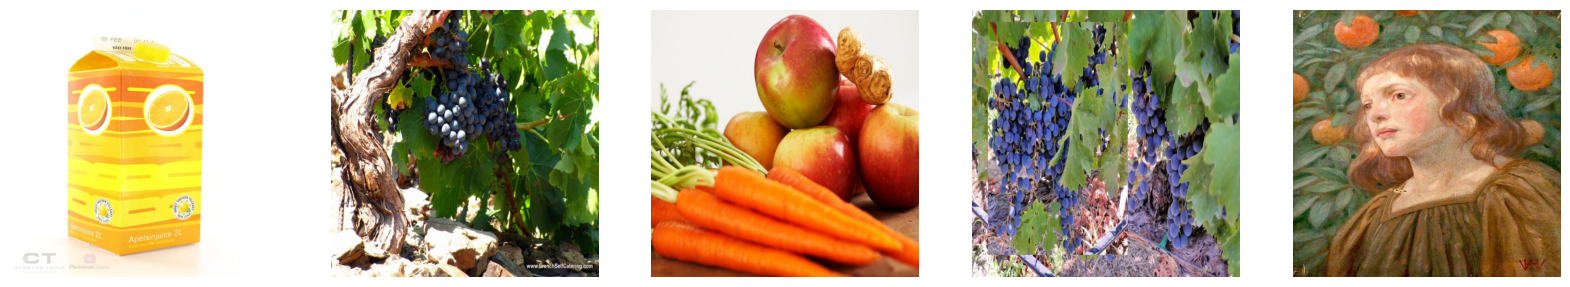

File: datasets/fruits_detection/train/labels/296dcc04e67d488d_jpg.rf.d5cddb68481e9e137c68f98f13d9ca44.txt
  3 0.0875 0.8359375 0.175 0.0734375
  3 0.16015625 0.7390625 0.048046875 0.06015625
  3 0.21015625 0.8078125 0.084375 0.10625
  3 0.22109375 0.72421875 0.07734375 0.071875
  3 0.35546875 0.834375 0.219921875 0.056640625
File: datasets/fruits_detection/train/labels/10ed49e38561d2ee_jpg.rf.906fd348a4714b3023c1abd6457d39bd.txt
  3 0.34140625 0.9546875 0.109375 0.07578125
  3 0.49921875 0.496875 0.9984375 0.99375
  3 0.92578125 0.6 0.08203125 0.0515625
File: datasets/fruits_detection/train/labels/0d3552244f815943_jpg.rf.e5185eee5c8da821edccd1dd6251f6b7.txt
  4 0.81171875 0.71484375 0.230078125 0.567578125
File: datasets/fruits_detection/train/labels/2adb3caf055459cb_jpg.rf.261d4f922e50bdcdf88b1afa7980dcff.txt
  3 0.37578125 0.5875 0.2375 0.32421875
File: datasets/fruits_detection/train/labels/0b39979279b3b8aa_jpg.rf.07dece866123e5a5b7995137bf70313e.txt
  0 0.46875 0.26953125 0.4121093

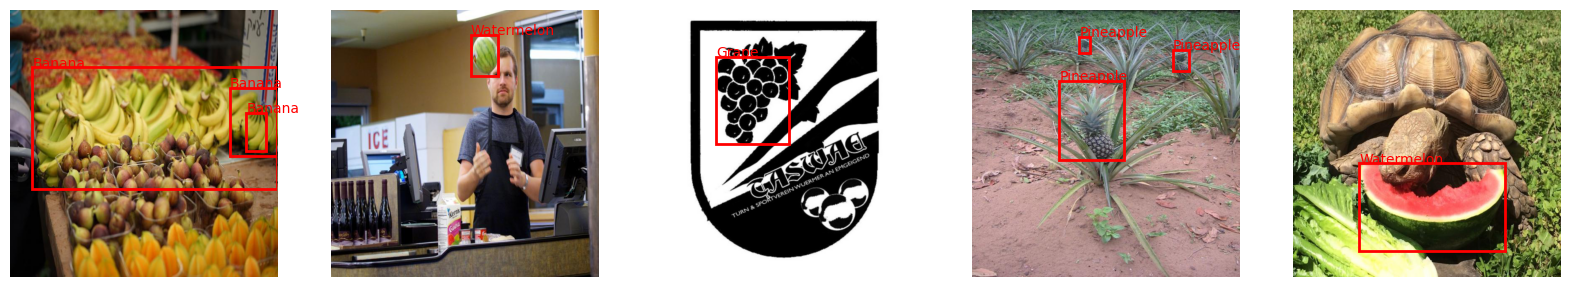

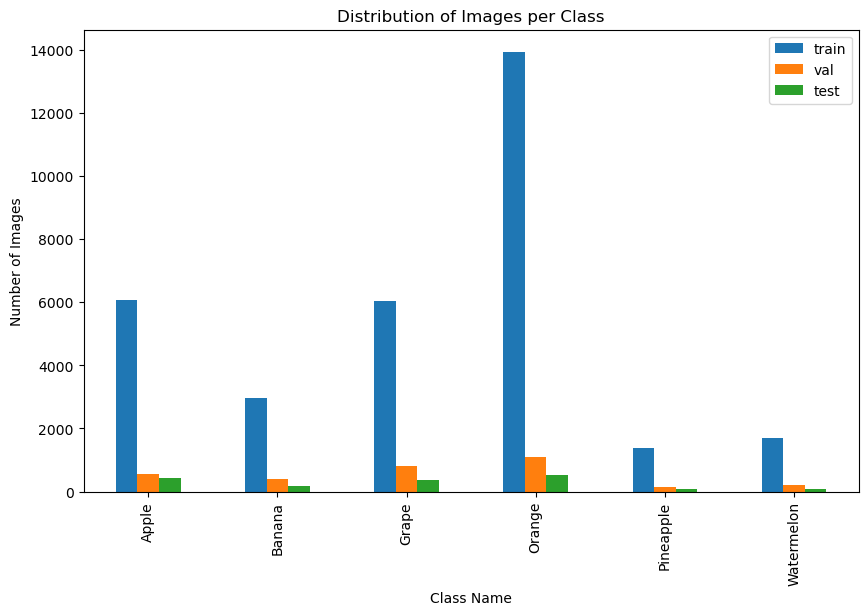

In [3]:
# Assign the path to the dataset
data_dir = r"datasets/fruits_detection"

# Make a histogram of the number of images in each class
def explore_data(data_dir, show_picture=True, show_annotation=True, show_detection=True, show_hist=True):

    # Define the class names
    class_names = ['Apple', 'Banana', 'Grape', 'Orange', 'Pineapple', 'Watermelon']
    
    # Examine some sample images
    if show_picture:
        # Get valid image folders 
        image_folders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))] 

        sample_images = []
        for i in range(5):
            folder = random.choice(image_folders) 
            img_path = os.path.join(data_dir, folder, 'images', random.choice(os.listdir(os.path.join(data_dir, folder, 'images'))))
            sample_images.append(img_path)

        # Plot the sample images
        fig, axes = plt.subplots(1, 5, figsize=(20, 5))
        for i, img_path in enumerate(sample_images):
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].axis('off')
        plt.show()

    # Examine the first five annotation files
    if show_annotation:
        annotation_files = []
        for folder in os.listdir(data_dir):
            if os.path.isdir(os.path.join(data_dir, folder)):
                annotation_folder = os.path.join(data_dir, folder, 'labels')
                if os.path.exists(annotation_folder):
                    for file in os.listdir(annotation_folder):
                        annotation_files.append(os.path.join(annotation_folder, file))
        for file in annotation_files[:5]:
            with open(file, 'r') as f:
                print(f"File: {file}")
                for i, line in enumerate(f):
                    if i > 4:
                        break
                    print(f"  {line.strip()}")

    # Plot five random images with their associated, labeled bounding boxes
    if show_detection:
        # Get valid image folders 
        image_folders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))] 

        sample_images = []
        for i in range(5):
            folder = random.choice(image_folders) 
            img_path = os.path.join(data_dir, folder, 'images', random.choice(os.listdir(os.path.join(data_dir, folder, 'images'))))
            annotation_path = os.path.join(data_dir, folder, 'labels', os.path.basename(img_path).replace('.jpg', '.txt'))
            sample_images.append((img_path, annotation_path))

        # Plot the sample images
        fig, axes = plt.subplots(1, 5, figsize=(20, 5))
        for i, (img_path, annotation_path) in enumerate(sample_images):
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].axis('off')
            with open(annotation_path, 'r') as f:
                for line in f:
                    class_id, x, y, w, h = map(float, line.strip().split())
                    x, y, w, h = x * img.width, y * img.height, w * img.width, h * img.height
                    rect = plt.Rectangle((x - w / 2, y - h / 2), w, h, fill=False, color='red', linewidth=2)
                    axes[i].add_patch(rect)
                    # Add class name above the bounding box
                    axes[i].text(x - w / 2, y - h / 2, class_names[int(class_id)], color='red')
        plt.show()


    # Make a histogram of the number of images in each class
    if show_hist:
        def get_class_counts(folder_path):  # Change from data_dir to folder_path
            class_counts = {}
            labels_path = os.path.join(folder_path, 'labels')  # Add labels path
            for filename in os.listdir(labels_path):  # Update listdir
                with open(os.path.join(labels_path, filename), 'r') as f:
                    for line in f:
                        class_id = int(line.split(' ')[0])  # Assuming labels are in YOLO format
                        class_counts[class_id] = class_counts.get(class_id, 0) + 1
            return class_counts

        train_counts = get_class_counts(os.path.join(data_dir, 'train'))  # Add os.path.join
        val_counts = get_class_counts(os.path.join(data_dir, 'valid'))
        test_counts = get_class_counts(os.path.join(data_dir, 'test'))
        num_classes = len(class_names)

        data_counts = {
            'train': pd.Series(train_counts),
            'val': pd.Series(val_counts),
            'test': pd.Series(test_counts)
        }
        df = pd.DataFrame(data_counts)

        df.plot.bar(figsize=(10, 6))
        plt.xlabel('Class Name')
        plt.xticks(np.arange(num_classes), class_names)
        plt.ylabel('Number of Images')
        plt.title('Distribution of Images per Class')
        plt.legend()
        plt.show()

explore_data(data_dir, show_picture=True, show_annotation=True, show_detection=True, show_hist=True)

There's a lot to unpack here! First, depending on the images sampled, we can see that the images are of different sizes and have different numbers of fruits. Other things to note:
- Some of the images don't really contain fruits...
- The file names are the same as the image names, but with a .txt extension.
- The annotations file contains the class ID of the fruit (0 corresponds to 'Apple', etc.), and the bounding box coordinates. 
- The bounding box coordinates are in the format (x_min, y_min, x_max, y_max).
- The bounding box coordinates are normalized, meaning that they are scaled to be between 0 and 1. This is a common practice in object detection tasks.
- The bounding boxes in some of the images are not very accurate. This is a common problem in object detection tasks.
- The dataset is very imbalanced, with a lot more oranges than other fruits.

## 4. Create the YAML file
YAML stands for "YAML Ain't Markup Language" and is a human-readable data serialization format. A YAML file is used to define the dataset configuration for training a YOLOv8 model. YAML configuration files are popular in deep learning because they are easier for humans to read and write, with the goal being to increase transparency and reproducibility.

In [ ]:
# Create a YAML file for the YOLOv8 model configuration

def create_yaml(data_dir, class_names, yaml_file='fruits_detection_data.yaml'):
    # Creates a YOLOv8 data.yaml file.
    
    yaml_dict = {
        # 'path': data_dir,  # Path to your dataset
        'train': data_dir + '/train/images',  # Relative path to training images
        'val': data_dir + '/valid/images',    # Relative path to validation images
        'test': data_dir + '/test/images',    # Relative path to testing images

        'num_classes': len(class_names),   # Number of classes
        'names': class_names      # List of class names
    }

    with open(yaml_file, 'w') as outfile:
        yaml.dump(yaml_dict, outfile, default_flow_style=False)

    print(f'YAML file created: {yaml_file}')

data_dir = 'fruits_detection'
class_names = ['Apple', 'Banana', 'Grape', 'Orange', 'Pineapple', 'Watermelon']

create_yaml(data_dir, class_names) 

## 5. Create and fit the model

We will create a YOLOv8 model and fit it to the data. YOLOv8 has a lot of hyperparameters that can be tuned, but we will use the default values for now. For more information on the it's hyperparameters, [check out it's documentation](https://docs.ultralytics.com/modes/train/).

Another neat feature of YOLOv8 is that by default it provides several evaluation metrics, such as the loss, precision, recall, and F1 score. This is very useful for monitoring the model's performance during training.

In [4]:
# Make the YOLOv8 model
model = YOLO('yolov8n.yaml')
results = model.train(data='fruits_detection_data.yaml', imgsz=640, epochs=10)

New https://pypi.org/project/ultralytics/8.2.2 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.9 🚀 Python-3.8.18 torch-2.3.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81051MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=fruits_detection_data.yaml, epochs=10, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=Fal

train: Scanning /home/i.lutticken/computer_vision/datasets/fruits_detection/train/labels.cache... 7108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7108/7108 [00:00<?, ?it/s]

train: WARNING ⚠️ /home/i.lutticken/computer_vision/datasets/fruits_detection/train/images/3d8be4f881b8c54c_jpg.rf.0d7b6d095459cece040b47b246d807af.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /home/i.lutticken/computer_vision/datasets/fruits_detection/train/images/3d8be4f881b8c54c_jpg.rf.64e869a9bedd5f012cc2a1129c6ca229.jpg: 1 duplicate labels removed



/home/i.lutticken/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /home/i.lutticken/computer_vision/datasets/fruits_detection/valid/labels.cache... 914 images, 0 backgrounds, 0 corrupt: 100%|██████████| 914/914 [00:00<?, ?it/s]

val: WARNING ⚠️ /home/i.lutticken/computer_vision/datasets/fruits_detection/valid/images/3d3ddc3054b32eb7_jpg.rf.03e7789aaf5212e2634b84ef502e0832.jpg: 1 duplicate labels removed



/home/i.lutticken/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic


/home/i.lutticken/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10       2.8G      3.087      4.328      3.801         59        640: 100%|█████████▉| 444/445 [01:08<00:00,  6.88it/s]/home/i.lutticken/.local/lib/python3.8/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
       1/10      2.84G      3.083      4.328      3.801          4        640: 100%|██████████| 445/445 [01:08<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.67it/s]

                   all        914       3227      0.689     0.0225     0.0113    0.00379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.91G      2.248       3.57      2.759         32        640: 100%|██████████| 445/445 [01:04<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.35it/s]


                   all        914       3227      0.269      0.106     0.0439     0.0215

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.65G      1.823      3.062      2.273          9        640: 100%|██████████| 445/445 [01:03<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.49it/s]


                   all        914       3227      0.305      0.126     0.0552     0.0286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      3.03G      1.659      2.761      2.071          8        640: 100%|██████████| 445/445 [01:03<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.70it/s]


                   all        914       3227       0.16      0.135     0.0675      0.035

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10       2.8G      1.564      2.585      1.955         18        640: 100%|██████████| 445/445 [01:03<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.56it/s]


                   all        914       3227      0.172      0.175     0.0992     0.0547

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.74G      1.479      2.422      1.861          4        640: 100%|██████████| 445/445 [01:04<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.62it/s]


                   all        914       3227      0.172      0.161     0.0963      0.054

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.64G      1.409      2.285      1.786         12        640: 100%|██████████| 445/445 [01:04<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.72it/s]


                   all        914       3227       0.24      0.216      0.115     0.0596

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10       2.8G      1.362      2.196      1.738          9        640: 100%|██████████| 445/445 [01:03<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:05<00:00,  4.92it/s]

                   all        914       3227      0.244      0.206      0.144     0.0803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.82G      1.324      2.092      1.695          9        640: 100%|██████████| 445/445 [01:03<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.59it/s]


                   all        914       3227      0.277      0.201      0.144     0.0768

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.84G      1.282      2.003      1.655         11        640: 100%|██████████| 445/445 [01:03<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.70it/s]


                   all        914       3227        0.3      0.219      0.172     0.0953

10 epochs completed in 0.199 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.9 🚀 Python-3.8.18 torch-2.3.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81051MiB)
YOLOv8n summary (fused): 168 layers, 3006818 parameters, 0 gradients


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.99it/s]


                   all        914       3227      0.297      0.219      0.171     0.0952
                 Apple        914        557      0.334      0.242        0.2      0.136
                Banana        914        390      0.403      0.146       0.16     0.0756
                 Grape        914        809      0.257      0.172       0.13     0.0558
                Orange        914       1100      0.377      0.348      0.276      0.162
             Pineapple        914        154      0.218      0.182      0.122     0.0577
            Watermelon        914        217      0.195      0.226      0.139     0.0839
Speed: 0.2ms preprocess, 0.8ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/train


## 6. Evaluate the results

Let's look at those evaluation metrics we mentioned above. YOLOv8 creates a **runs** folder that stores each training run. We'll pull them up here and examine what they mean.

Latest training run: train


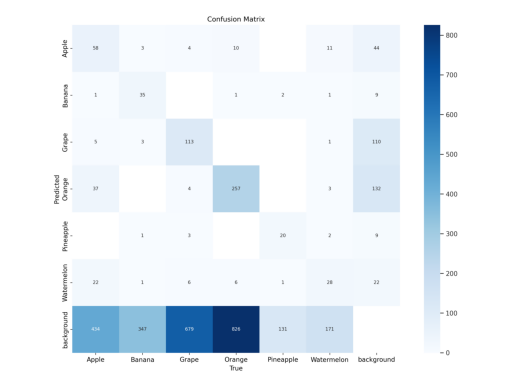

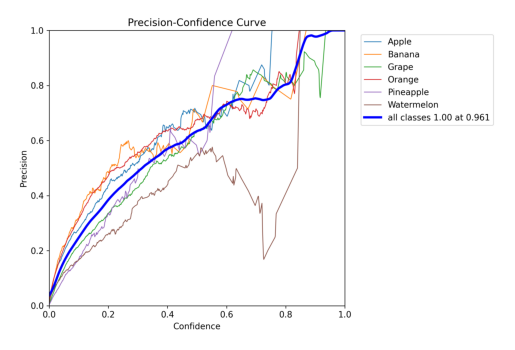

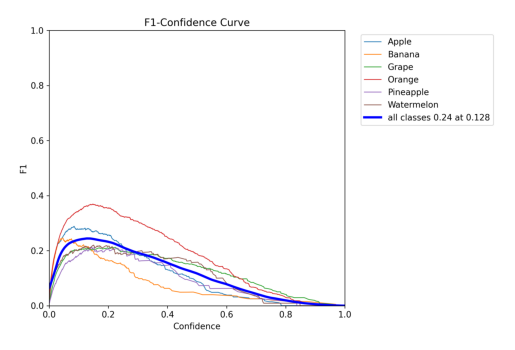

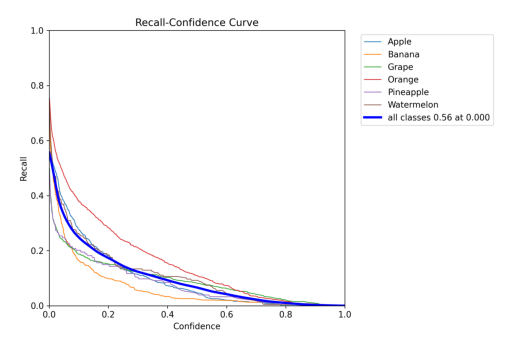

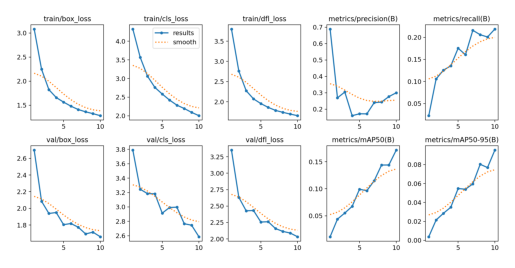

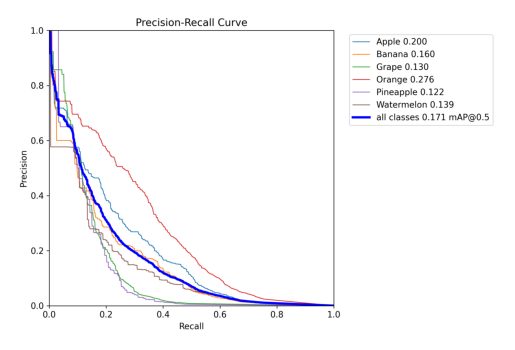

In [5]:
# Plot the evaluation results

# Find the latest training run
training = sorted(os.listdir('runs/detect/.'))
latest_training = training[-1]
print(f'Latest training run: {latest_training}')

# Plot the .png files in the latest training run
for file in os.listdir(f'runs/detect/{latest_training}'):
    if file.endswith('.png'):
        # Exclude the normalized confusion matrix since it's redundant
        if 'normalized' in file:
            continue
        img = Image.open(f'runs/detect/{latest_training}/{file}')
        plt.imshow(img)
        plt.axis('off')
        plt.show()

## Breaking down the graphs
If your stats are a little rusty like Kevin's, you might need a bit of refresher to make sense of the graphs above. Expand the section below for a rundown on the terms used above.

<details>
    
<summary><h2>Click to Expand for Stats Terms!</h2></summary>

<p>

##### What is Precision?
Precision is the ratio of correctly predicted positive observations to the total predicted positives. An example in our fruit object detection task would be the ratio of correctly predicted apples to the total predicted apples. Higher precision values are better, as they indicate that the model is making more accurate predictions.

##### What is Recall?
Recall is the ratio of correctly predicted positive observations to the all observations in actual class. An example in our fruit object detection task would be the ratio of correctly predicted apples to the total actual apples. Higher recall values are better, as they indicate that the model is making more accurate predictions.

##### What is Confidence?
Confidence is the probability that a model assigns to a prediction. In our fruit object detection task, the confidence is the probability that a model assigns to a fruit being an apple, orange, or any other fruit. Higher confidence values are better, as they indicate that the model is more certain about its predictions.

##### What is a confusion matrix?
A confusion matrix is a table that is often used to describe the performance of a classification model on a set of test data for which the true values are known. It allows the visualization of the performance of an algorithm. The confusion matrix shows the ways in which your classification model is confused when it makes predictions. It gives you insight not only into the errors being made by your classifier but more importantly the types of errors that are being made.

##### What is the F1 Confidence Curve?
The F1 Confidence Curve is a plot of the F1 score against the confidence threshold. The F1 score is the harmonic mean of precision and recall, and it is a measure of a model's accuracy. The confidence threshold is the minimum confidence level that a model must have in order to make a prediction. The F1 Confidence Curve is used to determine the optimal confidence threshold for a model. The curve shows how the F1 score changes as the confidence threshold is varied. The goal is to find the confidence threshold that maximizes the F1 score. The highest point on the curve tells you the optimal confidence threshold where the model strikes the best balance between precision and recall. In our fruit object detection task, the F1 Confidence Curve would show how the F1 score changes as the confidence threshold is varied for each fruit class. Higher F1 scores are better, as they indicate that the model is making more accurate predictions.
    
##### What is mAP50?
mAP50 stands for "mean Average Precision at 50% confidence". It is a common metric used in object detection tasks to evaluate the performance of a model. The mAP50 is the average of the precision values at different recall levels, where the recall is calculated at a confidence threshold of 50%. A higher mAP50 value indicates better performance.
    
##### What is mAP50-95?
mAP50-95 is the mean average precision (mAP) over the range of intersection over union (IoU) thresholds from 0.5 to 0.95. IoU is a measure of the overlap between two bounding boxes. It is calculated as the area of the intersection of the two bounding boxes divided by the area of their union. An IoU of 0 means that the two bounding boxes do not overlap at all, while an IoU of 1 means that the two bounding boxes are identical. The mAP50-95 metric is a more comprehensive metric than the mAP50 metric, which only considers the IoU threshold of 0.5. The mAP50-95 metric provides a more complete picture of the model's performance across a range of IoU thresholds.

</p>
</details>

In addition to those graphs, we can look at the predictions themselves. 

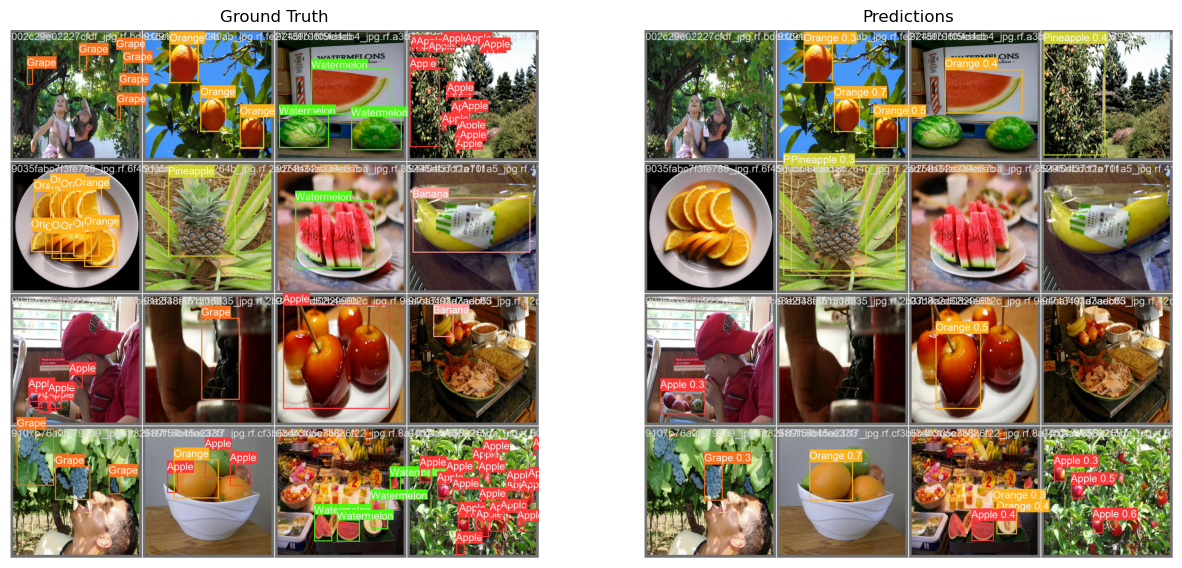

In [7]:
# Plot the labels and predictions from the last training run

# Load the images
img1 = Image.open(f'runs/detect/{latest_training}/val_batch0_labels.jpg')
img2 = Image.open(f'runs/detect/{latest_training}/val_batch0_pred.jpg')

# Plot the images
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(img1)
axes[0].axis('off')
axes[0].set_title('Ground Truth')
axes[1].imshow(img2)
axes[1].axis('off')
axes[1].set_title('Predictions')
plt.show()


From the prediction images, you'll probably notice this model loves its citrus. That's no surprise given the histogram we looked at at the beginning of this notebook. What could we do to improve this?

## 7. Inference
How does the model fair on some test images? After you run the cell below:
1. Find your own image of fruit.
2. Upload it to this folder.
3. Add or edit the code below to run on the new image rather than images in the test folder.


In [8]:
# Run the model on a few test images

# Run the model on a few Test images

# Get ten random test images
test_images = []
for folder in os.listdir(os.path.join(data_dir, 'test', 'images')):
    img_path = os.path.join(data_dir, 'test', 'images', folder)
    test_images.append(img_path)
test_images = random.sample(test_images, 10)

# Plot the test images
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
for i, img_path in enumerate(test_images):
    img = Image.open(img_path)
    axes[i // 5, i % 5].imshow(img)
    axes[i // 5, i % 5].axis('off')
plt.show()

# Run the model on the test images
infer_results = model.predict(test_images)

# Plot the results
for img_path, detections in zip(test_images, infer_results):
    img = Image.open(img_path)
    img = img.resize((640, 640))
    plt.imshow(img)
    plt.axis('off')
    for detection in detections:
        class_id, conf, box = detection
        x, y, w, h = box
        x1, y1, x2, y2 = x - w / 2, y - h / 2, x + w / 2, y + h / 2
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color='red', linewidth=2)
        plt.gca().add_patch(rect)
        plt.text(x1, y1, class_names[int(class_id)], color='red')


0: 640x640 1 Grape, 1 Pineapple, 1: 640x640 (no detections), 2: 640x640 2 Oranges, 3: 640x640 1 Orange, 4: 640x640 (no detections), 5: 640x640 (no detections), 6: 640x640 (no detections), 7: 640x640 (no detections), 8: 640x640 (no detections), 9: 640x640 (no detections), 171.6ms
Speed: 1.1ms preprocess, 17.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


AttributeError: 'list' object has no attribute 'pred'

## 8. Explore hyperparameters

Now that you have a good baseline, consider how you might deal with this model's issues.
- How would you address issues in the dataset?
- How would you optimize training?

A good first place to start would be YOLOv8's documentation so you can understand what hyperparameters you have access to and how changing them will affect training. Make some adjustments and see how high you can get your fruits object detection F1 score!

## Bonus Exercises

- You might have noticed the *yolov8n.pt* file that is added to the folder when you load YOLO. That is the pre-trained model using the [COCO dataset](https://cocodataset.org/#home). The YOLOv8 documentation linked above provides instructions for transer learning and fine-tuning with the pre-trained model. Give it a shot!

- If you're feeling very bold and want the full Object Detection Experience, find an image labeler and build your own dataset! If you use proprietary data, be sure that the software you use to label meets your institution's guidelines for data sharing. If you go this route, you will almost certainly want to use the fine-tuning option mentioned above, otherwise you're going to be spending quite a long time labeling...